# Example: Download, Process, and Visualize AZFP Data from ONC

In this example, you will download recent data from a bioacoustic sonar instrument located at ONC's Strait of Georgia Eas Venus Instrument Platform (SEVIP) site.

In [1]:
from datetime import datetime,timezone, timedelta
import echopype
import gsw
import numpy as np
import os

from ONCToolbox import ONCToolbox

# Update SV_OFFSET to be compatible with some ONC AZFP deployments.
# 0.9 is an arbitrary value for this example and should be verified with ASL and echopype before use in science.
echopype.convert.parse_azfp.SV_OFFSET[38000.0][800] = 0.9

In [2]:
save_dir = 'onc_data'

onct = ONCToolbox()

# Set up for the request of the last hour of data.
date_to = datetime.now(timezone.utc)
date_from = date_to - timedelta(minutes = 30)

## Download ONC Data

Uncomment the following cell to download data for this example.

In [3]:
location_code = 'SEVIP.E3'
device_category_code='ECHOSOUNDERBIOA'
extension='01a'
data_product_code='AAPTS'

down = onct.request_and_download_data_product(location_code = location_code,
                                              device_category_code=device_category_code,
                                              extension=extension,
                                              date_from = date_from, date_to = date_to,
                                              data_product_code=data_product_code)

Request Id: 27238325
Estimated File Size: 98 MB
Estimated Processing Time: 5 min
To cancel the running data product, run 'onc.cancelDataProduct(27238325)'

   queued
   data product running.................
   3 files generated for this data product
   complete



## Import the Downloaded AZFP Data

In [4]:
for file in down:
    if file['file'].endswith('01a'):
        raw_path = os.path.join(save_dir, file['file'])
    elif file['file'].endswith('.xml') and 'META' not in file['file']:
        xml_path = os.path.join(save_dir, file['file'])

ed = echopype.open_raw(raw_path, sonar_model='AZFP', xml_path = xml_path)

### Download Co-Located CTD Data

Download co-located CTD data to enable correction for environmental variables. In this example, we use the mean for the hour time-series of AZFP data previously downloaded.

In [5]:
location_code = 'SEVIP'
device_category_code='CTD'
ctd = onct.get_fullres_data(location_code = location_code,
                            device_category_code = device_category_code,
                            date_from = date_from, date_to = date_to, out_as = 'xarray', add_metadata = True)


# Use CTD time-series mean for correction.
# https://echopype.readthedocs.io/en/latest/api/echopype.calibrate.compute_Sv.html
mean_temp = float(ctd.temperature.mean())
mean_sal = float(ctd.practical_salinity.mean())
mean_pressure = float(ctd.pressure.mean())
mean_depth = float(gsw.z_from_p(mean_pressure, ctd.attrs['lat']) * -1)

environ_vars = {'temperature': mean_temp,
                'salinity': mean_sal,
                'pressure': mean_pressure}

### Calibrate

In [6]:
sv = echopype.calibrate.compute_Sv(ed, env_params = environ_vars)

### Denoise

In [7]:
sv = echopype.clean.remove_background_noise(
    sv, ping_num=5,
    range_sample_num=5,
    SNR_threshold="2.0dB",
)

### Assign Depth

In [8]:
sv = echopype.consolidate.add_depth(sv, depth_offset = mean_depth, downward = False)

### Compute Mean Volume Backscatter and Apply to Grid

In [9]:
mvbs = echopype.commongrid.compute_MVBS(sv, range_var = 'depth',range_bin = '0.5m', ping_time_bin = '10s', reindex = False, fill_value = np.nan)
mvbs = echopype.consolidate.swap_dims_channel_frequency(mvbs)

## Plotting with Matplotlib

In [10]:
import matplotlib.pyplot as plt

In [11]:
mvbs120 = mvbs.sel(frequency_nominal=120000)

x = mvbs120.ping_time
y = mvbs120.depth
Y,X = np.meshgrid(y,x)
Z = mvbs120.Sv

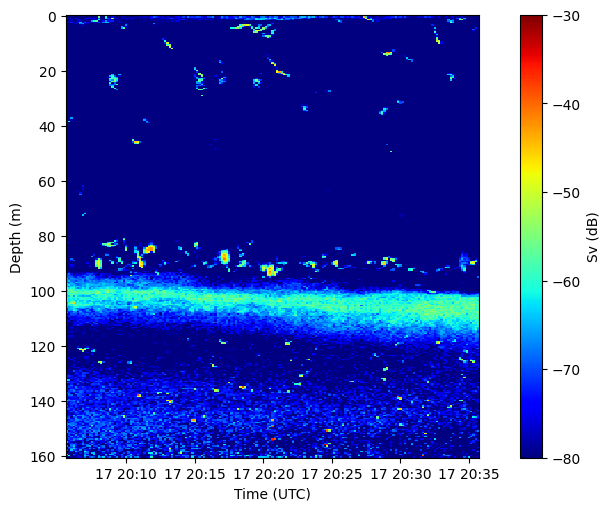

In [12]:
fig, ax = plt.subplots(1,1, figsize = (6,5), constrained_layout = True)

pmesh = ax.pcolormesh(X,Y,Z, vmin = -80, vmax = -30, cmap = 'jet')
ax.invert_yaxis()

ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Depth (m)')
fig.colorbar(pmesh, ax = ax, label = 'Sv (dB)')

## Plotting with hvplot

In [13]:
import hvplot.xarray

In [14]:
mvbs["Sv"].hvplot.image(
    x="ping_time", y="depth",
    color="Sv", rasterize=True,
    cmap="jet", clim=(-80, -30),
    xlabel="Time (UTC)",
    ylabel="Depth (m)",
).options(height=800, invert_yaxis=True)


:DynamicMap   [frequency_nominal]
   :Image   [ping_time,depth]   (Mean volume backscattering strength (MVBS, mean Sv re 1 m-1))